# Analyzing the occurrence of emotions within movie trailers over time utilizing Object, Face and Emotion detection models

### Operationalization: 2021

## Explanation feature:
In this part I chose to analyse the occurrence of emotions within movie trailers over time-periods. The time series which the sub-datasets contain can be interesting to see whether certain emotions have increased or decreased between the periods, what the most occurring emotion is in each period, if there are differences/similarities in the occurrence of emotions within and between time-periods.

## Plan for tackling the dimensionality:

Within this analysis, the focus is on the center of each scene of the trailers because we are interested in the emotions that occur in trailers to get an idea of the distribution over the years/periods. This results in an overview of emotions occurring in each trailer and avoids getting emotions of the same images. The reason for not computing every frame is due to slowing down the process and not improving it. In addition, we have chosen not to apply emotions of a single frame because it will not represent the entire emotions occurring within a trailer. For comparing the periods/subsets we will concatenate them to a final data-frame and group them on periods for analysis purposes. This will give us the possibility to have the results of all time-periods. Then, the final dataset will be used to render different plots such as time-series with the occurrence of emotions per time point/period, pattern similarity and standard deviation per period. Which will give us the possibility to analyse the emotions over time-periods.

In order to answer the question, emotions within each trailer have to be extracted. For this we will use the method 'Emotion classification':

- Scene detection: we will use this technique to extract the scenes so we can use it for the face detection.

- Face detection: we will use this technique, cascading classifier, to detect faces which is then used as input for the Emotion classification step.

- Emotion classification: we will use this technique, 'fer2013_mini_XCEPTION', to detect the emotions within each scene. This will give us an idea of the occurring emotions within each trailer and time-period.


## Approach

First we need to load in the trailers. Then apply scene detection for getting the scenes within each trailer. In order to extract the relevant feature emotions, we first retrieve the faces by applying face classification and then pass it to the emotion classification to recognize the emotions. Finally, we concatenate the periods and plot this data to answer our question.

# Phase 1: preparation

For being able to use the methods mentioned in the method part we first have to install and download them. Then we will declare the needed libraries for the coding part.

In [1]:
!pip install opencv-python
!pip install scenedetect

In [2]:
!wget https: // raw.githubusercontent.com / opencv / opencv / master / data / haarcascades / haarcascade_frontalface_default.xml
!wget https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5

--2022-01-16 13:01:52--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
URL transformed to HTTPS due to an HSTS policy
--2022-01-16 13:01:52--  https://raw.githubusercontent.com/
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ [following]
--2022-01-16 13:01:52--  https://github.com/
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.8’

index.html.8            [  <=>               ] 270.15K  1.20MB/s    in 0.2s    

202

Below you will find the list of the imported libraries for being able to use certain functions for desired usage.

In [3]:
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import os
from collections import Counter
import numpy as np
from scenedetect import VideoManager
from scenedetect import SceneManager
from scenedetect.detectors import ContentDetector
import matplotlib.pyplot as plt

Explanation of library usage

- pandas: this package will be used to be able to read data and managing data(transforming, adding, removing etc.)
- tensorflow: for loading models
- cv2: for loading and transforming images
- os: for managing system files
- collections: for using Counter to count occurrences of emotions
- numpy: for manipulating arrays
- scenedetect: for detecting and managing scenes
- matplotlib: to visualize data within plot

# Phase 2: extract feature

In this phase we will load the trailers, apply scene detection and extract the relevant feature, so we can apply analysis in phase 3.


### Step 1: load trailers

Within this step we will first load the trailers dataset. Then load all video-trailers in subsets from the directory, combine the year column from the trailers dataset and store the paths and year in a dataframe for later usage in the features part.

In [4]:
# loads trailers data set
df_trailers = pd.read_csv('../data/trailers.csv')
df_trailers.head()

,trailer_title,url,imdb_id,year,rating,votes,genre
0,THE BIG PARADE trailer,https://archive.org/download/TheBigParadeTrail...,15624,1925,7.9,6148.0,Drama|Romance|War
1,ALL QUIET ON THE WESTERN FRONT 1930 trailer,https://archive.org/download/AllQuietOnTheWest...,20629,1930,8.0,56948.0,Drama|War
2,THE OREGON TRAIL trailer,https://archive.org/download/TheOregonTrailTra...,20691,1926,7.2,3353.0,Adventure|Romance|Western
3,FIVE STAR FINAL trailer,https://archive.org/download/FiveStarFinalTrai...,21873,1931,7.2,1790.0,Crime|Drama
4,LITTLE CAESAR trailer,https://archive.org/download/LittleCaesarTrail...,21079,1931,7.3,11958.0,Action|Crime|Drama|Romance


In [5]:

def reconstruct_data(dir_path, df_trailers, attribute):
    """
    reconstruct the downloaded files into df form with desired attribute from trailers dataset
    :param dir_path: path where the video trailers are stored
    :param df_trailers: dataset containing information of the trailers
    :param attribute: the additional attribute gained from df_trailers for the return dataset
    :return: a dataset with the desired attributes
    """

    # get file names within directory
    fnames = os.listdir(dir_path)
    # to store matched indexes
    idxs = []
    # to store file paths
    file_paths = []

    # loops over urls from df_trailer and only processes when a match occurs with the fnames
    # because the dataset is not big then using enumerate is just fine for time complexity
    for idx, url in enumerate(list(df_trailers.url.values)):
        # get file name from url
        fname = url.split('/')[-1]
        # when url file name is within the fnames array then...
        if fname in fnames:
            # add full file path
            file_paths.append(f'{dir_path}/{fname}')
            # add index of the match
            idxs.append(idx)
    # get all matched indexes from df_trailers with the desired attribute
    df_to_return = df_trailers.iloc[idxs].copy()[attribute]
    # store the file paths in the new data frame
    df_to_return['file_path'] = file_paths
    # returns the new data frame
    return df_to_return

In [6]:
# path to the desired directory
directory = '../data'

df_1920_1940 = reconstruct_data(f'{directory}/df_1920_1940', df_trailers, ['year'])
df_1960_1980 = reconstruct_data(f'{directory}/df_1960_1980', df_trailers, ['year'])
df_2000_2020 = reconstruct_data(f'{directory}/df_2000_2020', df_trailers, ['year'])

In [7]:
print(f'1920-1940 data size: {len(df_1920_1940)} \t 1960-1980 data size: {len(df_1960_1980)} \t 2000-2020 data size: {len(df_2000_2020)}')

1920-1940 data size: 10 	 1960-1980 data size: 10 	 2000-2020 data size: 10


### Step 2: choosing threshold
Now that we have the trailers loaded with desired attributes we will continue with the following step where we will choose a solid threshold for the scenes to avoid duplicates. The solid threshold will be used in the next step.

In [8]:
def fetch_single_frames(scene_list, cap):
    """
    fetch a single frames
    :param scene_list: a list of scenes
    :param cap: cap
    :return: a list of single frames
    """

    # stores single frames
    frames = []

  # saves the middle frame of each scene
    for start_time, end_time in scene_list:
        duration = end_time - start_time
        frame = (start_time.get_frames() + int(duration.get_frames() / 2))
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    return frames


def find_scenes(video_path, threshold=30.0):
    """
    fetches scenes
    :param video_path: path of the video trailer
    :param threshold: desired threshold
    :return: a list of scenes
    """
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=threshold))
    base_timecode = video_manager.get_base_timecode()
    video_manager.set_downscale_factor()
    video_manager.start()

    # detects scenes
    scene_manager.detect_scenes(frame_source=video_manager, show_progress=False)

    # returns a list of scenes
    return scene_manager.get_scene_list(base_timecode)

Finding a solid threshold for gray movies.

In [9]:
filename = df_1920_1940.file_path.iloc[0]

scene_arr = find_scenes(filename, 10)
print(f'threshold 10 has {len(scene_arr)} scenes')

scene_arr = find_scenes(filename, 20)
print(f'threshold 20 has {len(scene_arr)} scenes')


threshold 10 has 17 scenes
threshold 20 has 1 scenes


According to the results a threshold of 10 is solid for gray movies. Now, for colored movies the higher the threshold the fewer duplicates will occur. So lets see if 50 is any better than the default value 30.

In [10]:
def plot_frames(frames, title='', nrows = 3, ncols=4, figsize=(15, 10)):
    """
    plots frames in a collage
    :param frames: frames
    :param title: title for the plot
    :param nrows: n rows
    :param ncols: n columns
    :param figsize: figure size
    """
    # declare subplots
    fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=figsize)
    # add title
    fig.suptitle(title, fontsize=16)
    # render each frame into a plot
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(frames[i])
    plt.tight_layout()

In [11]:
filename = df_2000_2020.file_path.iloc[0]
cap = cv2.VideoCapture(filename)
scene_arr = find_scenes(filename, 30)
print(f'threshold 30 has {len(scene_arr)} scenes')

threshold 30 has 48 scenes


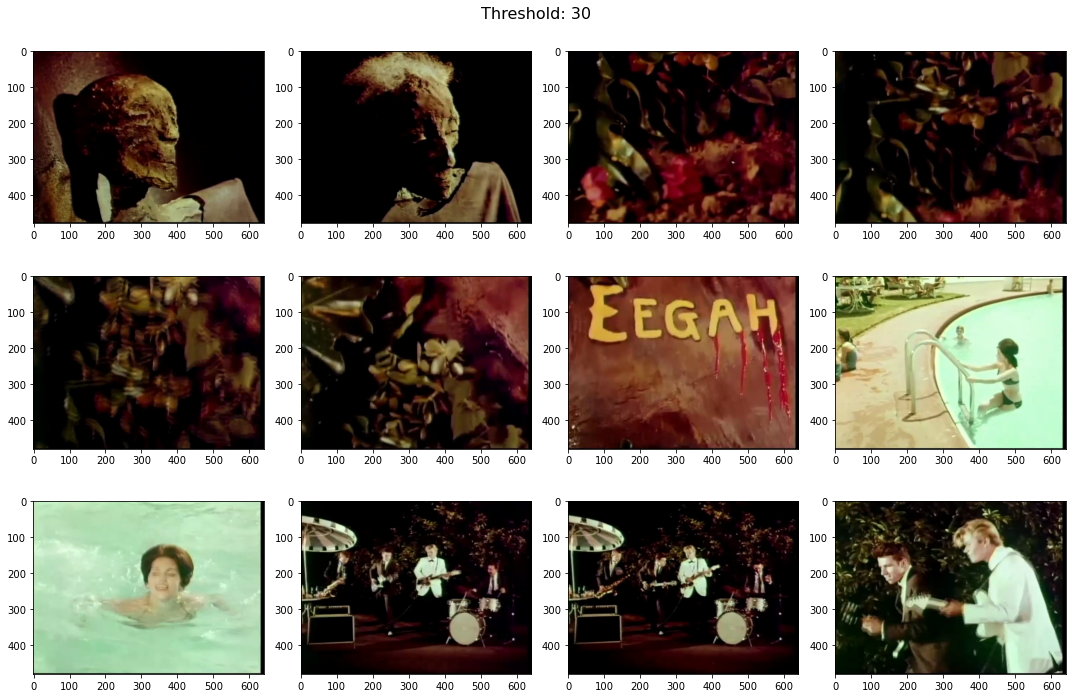

In [12]:
frames = fetch_single_frames(scene_arr, cap)
plot_frames(frames, 'Threshold: 30', 3, 4, (15,10))

In [13]:
scene_arr = find_scenes(filename, 50)
print(f'threshold 50 has {len(scene_arr)} scenes')

threshold 50 has 22 scenes


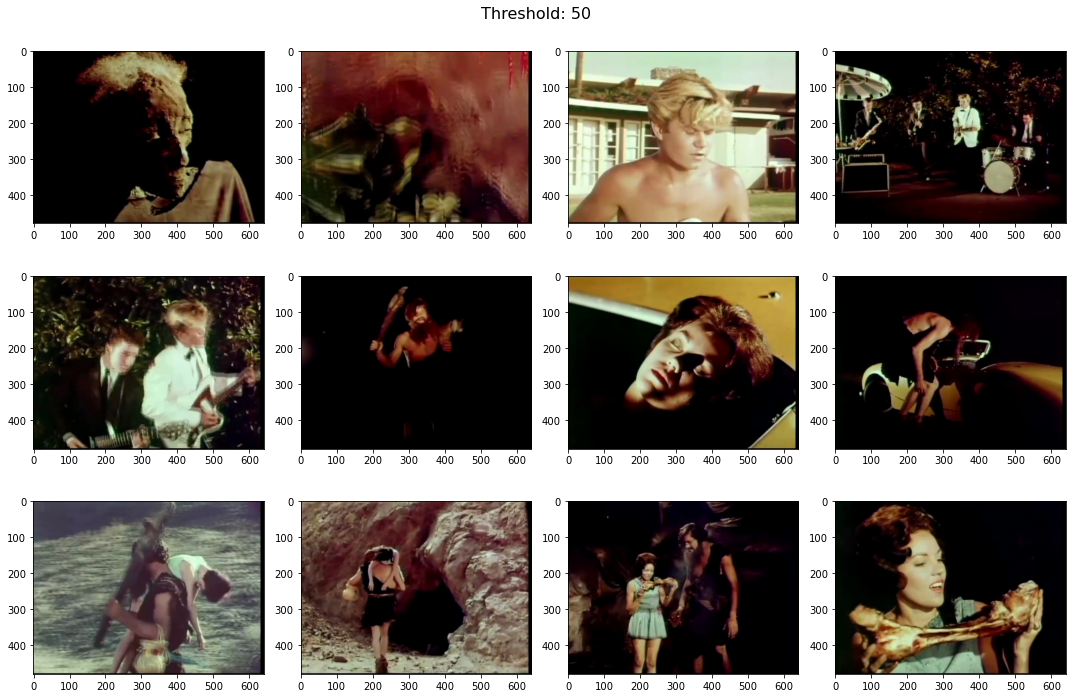

In [14]:
frames = fetch_single_frames(scene_arr, cap)
plot_frames(frames, 'Threshold: 50', 3, 4, (15,10))

From the sample frames of both threshold for color video we can see that 30 delivers duplicates compared to threshold 50. For this reason we will continue with threshold 50.

### Step 3: applying scene detection, face classification and emotion recognizer

Now that we have a solid threshold we will continue with the following step where we will apply a combination of scene detection, face classification and emotions recognizer to get the emotions of all scenes. Firstly, we will get the middle of the scenes, then get the faces which will be the input for the emotions recognizer to get the occurring emotions. Secondly, merge all periods into one dataset for comparison purposes in the analysis part.

In [15]:
# for flattening higher dimension arrays
flatten = lambda t: [item for sublist in t for item in sublist]


def apply_offsets(face_coordinates, offsets):
    """
    function for applying offsets for the face coordination's

    Derived from https://github.com/oarriaga/face_classification/blob/
    b861d21b0e76ca5514cdeb5b56a689b7318584f4/src/utils/inference.py#L21
    """
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)


def get_faces(frame, face_classification, scale_factor=1.2):
    """
    function for getting faces from the images by using face classification
    :param image_path: image path
    :param face_classification: face classification model
    :return: detected faces and gray image
    """
    gray_image = np.squeeze(frame).astype('uint8')
    # detecting faces
    detected = face_classification.detectMultiScale(gray_image, scale_factor, 5)

    if len(detected) == 0:
        # # changing rescaling factor for bigger faces otherwise they won't be detected
        # https://towardsdatascience.com/computer-vision-detecting-objects-using-haar-cascade-classifier-4585472829a9
        detected = face_classification.detectMultiScale(gray_image, 1.01, 5)

    return detected, gray_image


def preprocess_frame(frame, single_batch=False,  color_mode='rgb'):
    """
    preprocessing frame to a desired representation
    :param frame: frame
    :param single_batch: batch
    :param color_mode: desired color mode
    :return: new state of the frame
    """
    frame = cv2.resize(frame, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

    if color_mode == 'grayscale':
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if single_batch:
        frame = tf.expand_dims(frame, 0)
    return frame


def get_emotions(faces_map, emotion_classifier, labels, EMOTION_OFFSETS, INPUT_SHAPE_EMOTION):
    """
    function for getting emotions by using emotion classifier
    :param faces_map: the faces retrieved from face classification
    :param emotion_classifier: emotion classifier
    :param labels: labels with emotion expressed in human language
    :param EMOTION_OFFSETS: emotion offset for face coordinates
    :param INPUT_SHAPE_EMOTION: input shape for resizing face image
    :return: occurrence of emotions as array
    """
    occurring_faces = faces_map[0]
    gray_image = faces_map[1]
    occurring_emotions = []

    # looping over face coordinates for cutting purposes and retrieving related emotion
    for face_coordinates in occurring_faces:
        x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS)
        face_img = gray_image[y1:y2, x1:x2] # only get the face
        face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
        face_img = face_img.astype('float32') / 255.0 # pre-processing
        face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
        face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
        face_img = np.expand_dims(face_img, 0) # batch of one
        face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
        # predicting emotion
        probas = emotion_classifier.predict(face_img)
        # getting the related label
        label = labels[np.argmax(probas[0])]
        # storing in occurring_emotions array
        occurring_emotions.append(label)

    return occurring_emotions


def process_video(file_path, face_classifier, emotion_classifier, labels, EMOTION_OFFSETS, INPUT_SHAPE_EMOTION, threshold=50):
    """

    :param file_path: file path
    :param face_classifier: face classifier
    :param emotion_classifier: emotion classifier
    :param labels: emotion labels
    :param EMOTION_OFFSETS: emotion offset for face coordinates
    :param INPUT_SHAPE_EMOTION: input shape for resizing face image
    :param threshold: threshold for find scene function
    :return: occurrence of emotions as dictionary
    """

    # get scenes
    scene_arr = find_scenes(file_path, threshold)
    cap = cv2.VideoCapture(file_path)
    # get single frame from the scenes
    frames = fetch_single_frames(scene_arr, cap)

    # process frames, transform to grayscale for faces part
    processed_frames = [preprocess_frame(frame, color_mode='grayscale') for frame in frames]

    # get faces
    frame_x_faces = [get_faces(frame, face_classifier) for frame in processed_frames]

    # get emotions
    frame_x_emotions = [get_emotions(frame_face, emotion_classifier, labels, EMOTION_OFFSETS, INPUT_SHAPE_EMOTION) for frame_face in frame_x_faces]

    # flatten and get count of emotions
    occurrence = Counter(flatten(frame_x_emotions))

    return occurrence


def process_multi_videos(df, face_classifier, emotion_classifier, threshold):
    """
    function for processing multi videos for getting occurrence of emotions within each video trailer
    :param df: data frame with video trailer paths
    :param face_classifier: face classifier
    :param emotion_classifier: emotion classifier
    :param threshold: threshold for find scene function
    :return: a new data frame with the same attributes of the given dataframe with additional occurrence of each possible emotions
    """

    # emotion labels
    labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

    EMOTION_OFFSETS = (0, 0)
    INPUT_SHAPE_EMOTION = emotion_classifier.input_shape[1:3]

    # the new dataframe to return
    df_to_return = df.copy()
    # length of the dataframe
    L = len(df.file_path)

    # pre-reserving memory for operation purposes
    for label in labels:
        df_to_return[label] = 0

    # looping over each file path and threshold related to the video trailer cause apparently each trailer is either gray or color
    for idx in range(0, L):
        # file path
        fpath = df_to_return.file_path.iloc[idx]
        # related solid threshold which we already decided for gray and color
        solid_threshold = threshold[idx]
        # executing process video to get occurrences of emotions
        occurrence_emotions = process_video(fpath, face_classifier, emotion_classifier, labels, EMOTION_OFFSETS, INPUT_SHAPE_EMOTION, threshold=solid_threshold)

        # applying modification on cell level of attributes to add the occurrence
        for idy in range(0, len(labels)):
            label = labels[idy]
            # idy+2 so we don't touch the first 2 attributes
            df_to_return.iloc[idx, idy+2] = occurrence_emotions[label]

    return df_to_return


In [16]:
# loading face classifier
face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [17]:
# loading emotion classifier
emotion_classifier = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5')

Metal device set to: Apple M1 Pro


2022-01-16 13:03:15.357332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 13:03:15.357530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


After preparing the needed functions and classifiers, we will apply process_multi_videos for each time-period. Note, due to the threshold for color does not work with gray trailers and gray and color trailers are mixed within time-period we have to manually define the sequential order of gray and color threshold within each time period.

In [18]:
# solid thresholds for gray and color
bw_th = 10
color_th = 50

# hard-coding the sequential order of gray and color threshold within a time period
threshold_1920_1940 = [bw_th, bw_th, bw_th, bw_th, bw_th, color_th, bw_th, color_th, bw_th, bw_th]
threshold_1960_1980 = [color_th, color_th, bw_th] + ([color_th] * 7)
threshold_2000_2020 = ([color_th] * 8) + [bw_th, color_th]

df_1920_1940_cp = process_multi_videos(df_1920_1940, face_classification, emotion_classifier, threshold_1920_1940)
df_1960_1980_cp = process_multi_videos(df_1960_1980, face_classification, emotion_classifier, threshold_1960_1980)
df_2000_2020_cp = process_multi_videos(df_2000_2020, face_classification, emotion_classifier, threshold_2000_2020)

print('Finished processing')

2022-01-16 13:03:23.983872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-16 13:03:24.043079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Finished processing


In [39]:
df_1920_1940_cp['period'] = '1920_1940'
df_1960_1980_cp['period'] = '1960_1980'
df_2000_2020_cp['period'] = '2000_2020'

In [40]:
df_1960_1980_cp.head()

,year,file_path,angry,disgust,fear,happy,sad,surprise,neutral,period
423,1963,../data/df_1960_1980/YesterdayTodayAndTomorrow...,2,0,1,2,5,0,2,1960_1980
429,1964,../data/df_1960_1980/TheCurseOfTheMummysTombTr...,0,0,0,0,2,0,1,1960_1980
437,1964,../data/df_1960_1980/ChildrenOfTheDamnedTraile...,10,0,4,3,29,4,13,1960_1980
463,1966,../data/df_1960_1980/KhartoumTrailer.mp4,2,0,1,0,2,1,1,1960_1980
482,1968,../data/df_1960_1980/TheScalphuntersTrailer.mp4,8,0,1,6,10,0,3,1960_1980


In [41]:
print('Min and max year of each time-period:')
print(df_1920_1940_cp.year.min(), df_1920_1940_cp.year.max())
print(df_1960_1980_cp.year.min(), df_1960_1980_cp.year.max())
print(df_2000_2020_cp.year.min(), df_2000_2020_cp.year.max())

Min and max year of each time-period:
1931 1940
1963 1977
2001 2014


In [42]:
# concatenating each time-period as one dataset
df_all_periods = pd.concat([df_1920_1940_cp, df_1960_1980_cp, df_2000_2020_cp])
df_all_periods.to_csv('../data/all_emotios_periods.csv', index_label='idx_trailers_data')

In [43]:
df_all_periods = pd.read_csv('../data/all_emotios_periods.csv')
df_all_periods = df_all_periods.drop(columns=['idx_trailers_data', 'file_path'])

In [116]:
df_all_periods.period.value_counts()

1920_1940    10
1960_1980    10
2000_2020    10
Name: period, dtype: int64

# Phase 3: analysis
Now that we have our final dataset ready we can slowly enter the phase of applying statistical analysis, were we will plot our data and answer our question. First, we have to create a new dataframe where we have unique years because in the previous we have same year multiple time because a year can have multiple video trailers. So, we will sum the occurrences of emotions in a single year. This will make rendering the plots for analysis purposes easier.

In [61]:
# grouping by year
grouped_years = df_all_periods.groupby('year')
# only emotion labels
labels = df_all_periods.columns[1:-1]

# new dataframe with year as index for plotting purposes
df_freq_emotions = pd.DataFrame(index=set(df_all_periods.year))
# pre-reserve memory for operation purposes
df_freq_emotions[labels] = 0

# looping over each grouped year
for idx, year in enumerate(grouped_years):
    # summation of all label occurrence in all same year, because a year can occur multiple times but with different occurrence in labels we will just sum it as one
    # so we can perform a easy rendering of plots
    freq_year = sum(year[1].values[:,1:-1])
    # get related period
    period = year[1].values[0,-1]

    # loop over labels to update the label attributes in the new dataframe
    for i, label in enumerate(labels):
        df_freq_emotions.loc[year[0], label] = freq_year[i]

    # store the known period in the new dataframe, so we can realize groupby on periods
    df_freq_emotions.loc[year[0], 'period'] = period

In [67]:
df_freq_emotions.head()

,angry,disgust,fear,happy,sad,surprise,neutral,period
1931,6,1,1,3,5,0,1,1920_1940
1932,6,0,8,6,25,7,6,1920_1940
1934,3,0,2,0,7,1,3,1920_1940
1935,2,0,0,3,5,0,3,1920_1940
1936,16,0,2,9,30,2,9,1920_1940


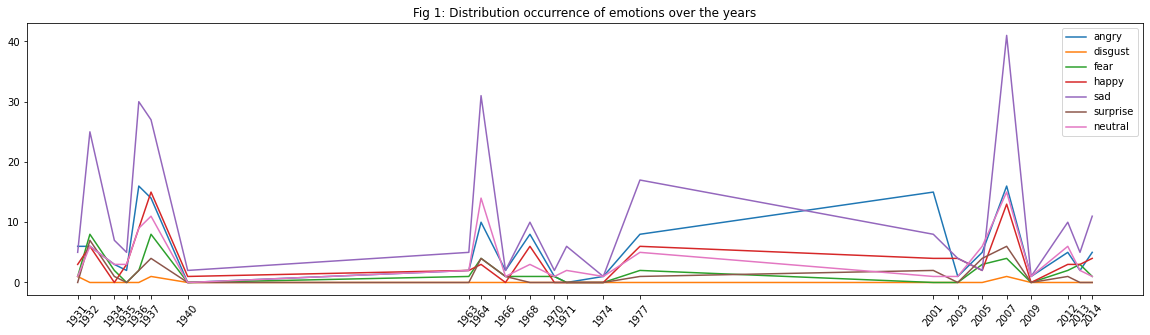

In [64]:
df_freq_emotions.plot(xticks=df_freq_emotions.index.values, rot=50, title='Fig 1: Distribution occurrence of emotions over the years', figsize=(20, 5));

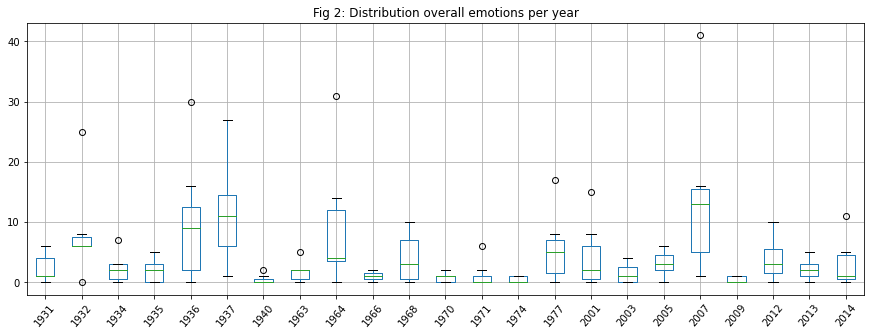

In [66]:
emotions_boxplot = df_freq_emotions.drop(columns=['period']).T.boxplot(figsize=(15, 5), rot=50);
emotions_boxplot.set_title('Fig 2: Distribution overall emotions per year');

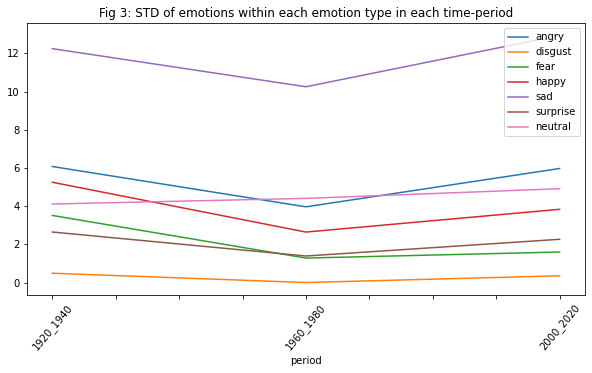

In [104]:
df_freq_emotions.groupby('period').std().plot(title='Fig 3: STD of emotions within each emotion type in each time-period', figsize=(10, 5), rot=50);

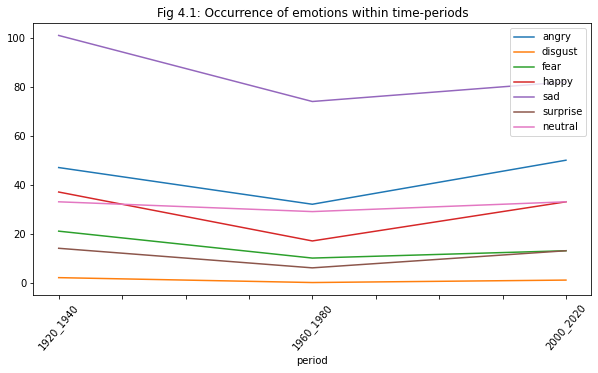

In [111]:
df_freq_emotions.groupby('period').sum().plot(title='Fig 4.1: Occurrence of emotions within time-periods', figsize=(10, 5), rot=50);

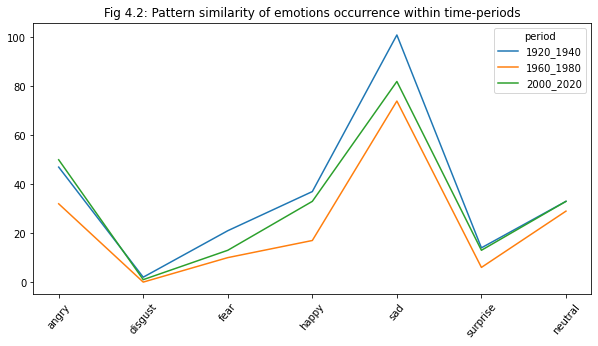

In [112]:
period_sum_boxplot = df_freq_emotions.groupby('period').sum().T.plot(figsize=(10, 5), rot=50);
period_sum_boxplot.set_title('Fig 4.2: Pattern similarity of emotions occurrence within time-periods');

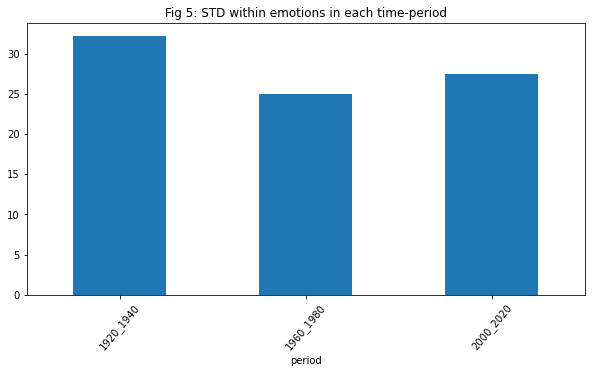

In [106]:
df_freq_emotions.groupby('period').sum().T.std().plot(title='Fig 5: STD within emotions in each time-period', kind='bar', figsize=(10, 5), rot=50);

## Plot information

- Fig 1: shows the occurrences of emotions per year. From the result we can see that emotion Sad is the most occurring emotion over the years whereas Disgust is the lowest.
- Fig 2: shows an overall emotions per year, were we see more emotions occurring in the years, 1936, 1937 and 2007.
- Fig 3: shows deviation of occurrence of an emotion within each time-period. The deviation of emotion Neutral is nearly same over time-periods with a slight increase.
- Fig 4: shows the sum of occurrences of an emotion in each time-period. Which tells us that the most occurring of an emotion in each time-period is Sad. The time-periods have similar pattern but with a slight different occurrence per emotion.
- Fig 5: shows the standard deviation within emotions in each time-period. Meaning that there is more different occurrence in emotions in 1920-1940 compared to other time-periods.

The final thoughts will be in the interpretation and conclusion section.


# Interpretation and conclusion

From the results we can conclude that there are actually differences in occurrence of emotions over the years, within and between time-periods. Emotion Sad is the most occurring emotion over the years whereas Disgust is the lowest. Some emotions have identical occurrence in certain periods such as Angry in 1920-1940 and 2000-2020 but lower in 1960-1980. Furthermore, we see a decrease and increase in the occurrence of certain emotions over time-periods. For example, most of the emotions decreased in period 1960-1980 compared to other periods whereas Neutral and Disgust stayed unchanged. This could be due to less occurrence of faces or emotional expressions in movie trailers within that period. We know that movies reflect culture through their narratives, characters and the way the movie makes us feel about contemporary issues. Therefore, the results might reflect contemporary issues within periods.  We see also a lower deviation of occurrence in Fear within periods 1960-1980 and 2000-2020. Meaning, both periods have nearly identical number of occurrences in fear whereas 1920-1940 has more different number of occurrence in Fear. Finally, there were apparently more different emotion occurrence in 1920-1940 than other periods. Meaning, in that time-period there were more different emotions occurring within video scenes. It could be that at that time it was normal to have a lot of different emotions in video trailers. Compared to other periods, it may not be a significant difference, but it does reflect a result that refers to a decrease in the difference of emotions.

### Data set construction:

The dataset consists of video trailer paths that reference movie trailers, the year of the movie and the occurrence of emotions.

### Documents consulted:

- https://www.tensorflow.org/
- https://matplotlib.org/
- https://pandas.pydata.org/docs/index.html